# **CELL 1 — Install libs & imports**

In [1]:
# EDA LLM Preference - ChatBot Arena

import os
import sys
import ast
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 10

print("✅ Imports OK")
print("📅", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

IN_COLAB = 'google.colab' in sys.modules
print("📌 In Colab:", IN_COLAB)


✅ Imports OK
📅 2025-12-11 20:29:13
📌 In Colab: True


# **CELL 2 — Project paths**

In [2]:
# Structure projet pour l'EDA
if IN_COLAB:
    BASE_DIR = "/content/projet_llm"
else:
    BASE_DIR = os.getcwd()

DATA_DIR = os.path.join(BASE_DIR, "data")
EDA_DIR = os.path.join(BASE_DIR, "notebooks", "eda")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(EDA_DIR, exist_ok=True)

print("📂 BASE_DIR:", BASE_DIR)
print("📂 DATA_DIR:", DATA_DIR)
print("📂 EDA_DIR :", EDA_DIR)


📂 BASE_DIR: /content/projet_llm
📂 DATA_DIR: /content/projet_llm/data
📂 EDA_DIR : /content/projet_llm/notebooks/eda


# **CELL 3 — Upload data**

In [3]:
from google.colab import files

print("📤 Veuillez uploader train.csv depuis votre PC...")
uploaded = files.upload()  # choisis train.csv

uploaded_filename = list(uploaded.keys())[0]
print("📥 Fichier reçu :", uploaded_filename)

DEST_PATH = os.path.join(DATA_DIR, "train.csv")
!mv "{uploaded_filename}" "{DEST_PATH}"

print("✅ train.csv déplacé vers :", DEST_PATH)

df = pd.read_csv(DEST_PATH)
print("✅ Données chargées :", df.shape)
df.head()


📤 Veuillez uploader train.csv depuis votre PC...


Saving train.csv to train.csv
📥 Fichier reçu : train.csv
✅ train.csv déplacé vers : /content/projet_llm/data/train.csv
✅ Données chargées : (57477, 9)


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


# **CELL 4 —Info de base & valeurs manquantes**

In [4]:
print("Colonnes :", df.columns.tolist())

print("\nTypes :")
print(df.dtypes)

print("\nPourcentage de valeurs manquantes :")
print((df.isna().mean() * 100).round(2).sort_values(ascending=False))

df.sample(3, random_state=42)


Colonnes : ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie']

Types :
id                 int64
model_a           object
model_b           object
prompt            object
response_a        object
response_b        object
winner_model_a     int64
winner_model_b     int64
winner_tie         int64
dtype: object

Pourcentage de valeurs manquantes :
id                0.0
model_a           0.0
model_b           0.0
prompt            0.0
response_a        0.0
response_b        0.0
winner_model_a    0.0
winner_model_b    0.0
winner_tie        0.0
dtype: float64


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
37379,2785062085,gpt-3.5-turbo-0613,codellama-34b-instruct,"[""what does hello world mean""]","[""\""Hello, World!\"" is a phrase used in comput...","[""\""Hello, World!\"" is a common phrase used to...",1,0,0
644,48259531,mistral-medium,gpt-4-0314,"[""I ran a marathon in 3:12:00 weighting 84kg. ...","[""It's difficult to provide an exact answer to...","[""To accurately estimate how much faster you w...",1,0,0
48496,3622731894,gpt-4-0314,gpt-3.5-turbo-0314,"[""Below is an instruction that describes a tas...","[""\u8fd9\u6b3e\u7eaf\u8272\u4e94\u5206\u88e4\u...","[""\u6839\u636e\u63d0\u4f9b\u7684\u4ea7\u54c1\u...",0,0,1


# **CELL 5 — Nettoyage léger des champs texte (listes → texte)**

In [5]:
def clean_text_field(x):
    """
    Transforme :
      - string représentant une liste: "[...]"  -> concaténation des éléments
      - vraie liste Python:             [...]   -> concaténation
      - string simple:                          -> strip
    """
    if isinstance(x, list):
        return " ".join([str(t) for t in x])

    if isinstance(x, str):
        s = x.strip()
        if s.startswith("[") and s.endswith("]"):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, list):
                    return " ".join([str(t) for t in parsed])
            except Exception:
                pass
        return s

    return str(x)


for col in ["prompt", "response_a", "response_b"]:
    if col in df.columns:
        df[col] = df[col].fillna("").apply(clean_text_field)

df[["prompt", "response_a", "response_b"]].head(3)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:

,prompt,response_a,response_b
0,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi..."
1,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...
2,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...


# **CELL 6 — Construire la cible winner + vérifier la distribution**

In [6]:
def compute_winner(row):
    if row.get("winner_model_a", 0) == 1:
        return 1
    elif row.get("winner_model_b", 0) == 1:
        return 0
    elif row.get("winner_tie", 0) == 1:
        return -1
    else:
        return -1  # sécurité

df["winner"] = df.apply(compute_winner, axis=1)

print("Distribution brute de winner (avec ties) :")
print(df["winner"].value_counts(dropna=False))
print("\nProportions :")
print((df["winner"].value_counts(normalize=True) * 100).round(2))


Distribution brute de winner (avec ties) :
winner
 1    20064
 0    19652
-1    17761
Name: count, dtype: int64

Proportions :
winner
 1    34.91
 0    34.19
-1    30.90
Name: proportion, dtype: float64


# **CELL 7 — Vérification cohérence des colonnes cible**

In [7]:
df["sum_winner_flags"] = df["winner_model_a"] + df["winner_model_b"] + df["winner_tie"]

print("Valeurs uniques de (winner_model_a + winner_model_b + winner_tie) :")
print(df["sum_winner_flags"].value_counts(dropna=False))

# Lignes bizarres (si jamais)
df_incoherent = df[df["sum_winner_flags"] != 1]
print("Nombre de lignes incohérentes :", df_incoherent.shape[0])
df_incoherent.head()


Valeurs uniques de (winner_model_a + winner_model_b + winner_tie) :
sum_winner_flags
1    57477
Name: count, dtype: int64
Nombre de lignes incohérentes : 0


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,winner,sum_winner_flags


# **CELL 8 — Suppression des ties pour l’analyse binaire**

In [8]:
df_binary = df[df["winner"] != -1].copy()
df_binary["winner"] = df_binary["winner"].astype(int)

print("Après suppression des ties :")
print(df_binary["winner"].value_counts())
print("\nProportions :")
print((df_binary["winner"].value_counts(normalize=True) * 100).round(2))


Après suppression des ties :
winner
1    20064
0    19652
Name: count, dtype: int64

Proportions :
winner
1    50.52
0    49.48
Name: proportion, dtype: float64


# **CELL 9 — Visualisation de la variable cible**

/tmp/ipython-input-1254359750.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Model B wins (0)", "Model A wins (1)"])


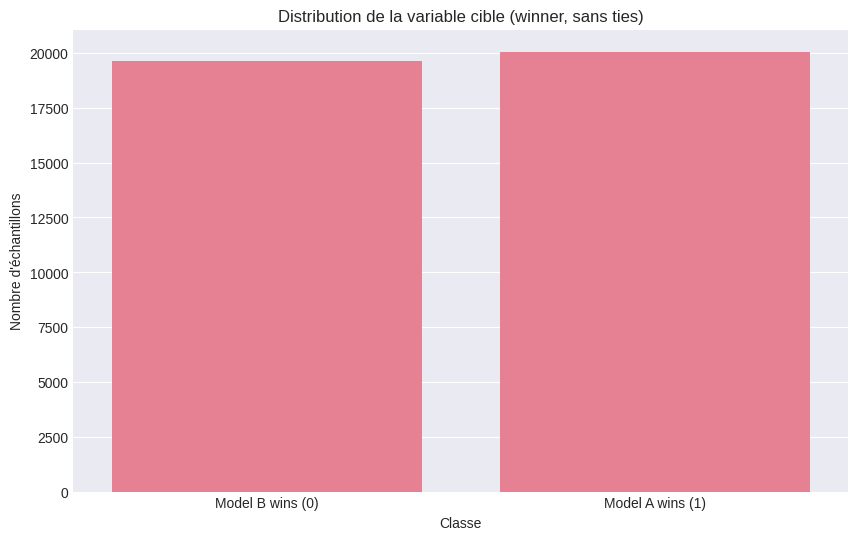

In [9]:
fig, ax = plt.subplots()
sns.countplot(x=df_binary["winner"], ax=ax)
ax.set_xticklabels(["Model B wins (0)", "Model A wins (1)"])
ax.set_title("Distribution de la variable cible (winner, sans ties)")
ax.set_xlabel("Classe")
ax.set_ylabel("Nombre d'échantillons")
plt.show()


# **CELL 10 — Feature engineering simple (longueurs & tokens)**

In [10]:
df_binary["len_prompt"] = df_binary["prompt"].str.len()
df_binary["len_a"] = df_binary["response_a"].str.len()
df_binary["len_b"] = df_binary["response_b"].str.len()

df_binary["tokens_prompt"] = df_binary["prompt"].str.split().apply(len)
df_binary["tokens_a"] = df_binary["response_a"].str.split().apply(len)
df_binary["tokens_b"] = df_binary["response_b"].str.split().apply(len)

df_binary["diff_len_ab"] = df_binary["len_a"] - df_binary["len_b"]
df_binary["diff_tokens_ab"] = df_binary["tokens_a"] - df_binary["tokens_b"]

df_binary[[
    "len_prompt", "len_a", "len_b",
    "tokens_prompt", "tokens_a", "tokens_b",
    "diff_len_ab", "diff_tokens_ab"
]].describe().T


,count,mean,std,min,25%,50%,75%,max
len_prompt,39716.0,345.383347,1023.166884,3.0,47.0,89.0,224.25,32839.0
len_a,39716.0,1383.481217,1503.445471,0.0,430.0,1100.0,1862.00,53299.0
len_b,39716.0,1391.123351,1508.577382,0.0,437.0,1106.0,1873.00,45563.0
tokens_prompt,39716.0,54.858747,149.994939,1.0,9.0,16.0,39.00,4809.0
tokens_a,39716.0,220.087119,232.552102,0.0,72.0,179.0,298.00,9184.0
tokens_b,39716.0,221.063904,231.700647,0.0,73.0,180.0,298.00,6893.0
diff_len_ab,39716.0,-7.642134,1116.847170,-19863.0,-471.0,0.0,454.00,42783.0
diff_tokens_ab,39716.0,-0.976785,174.715548,-3437.0,-77.0,0.0,74.00,7330.0


# **CELL 11 — Distributions des longueurs**

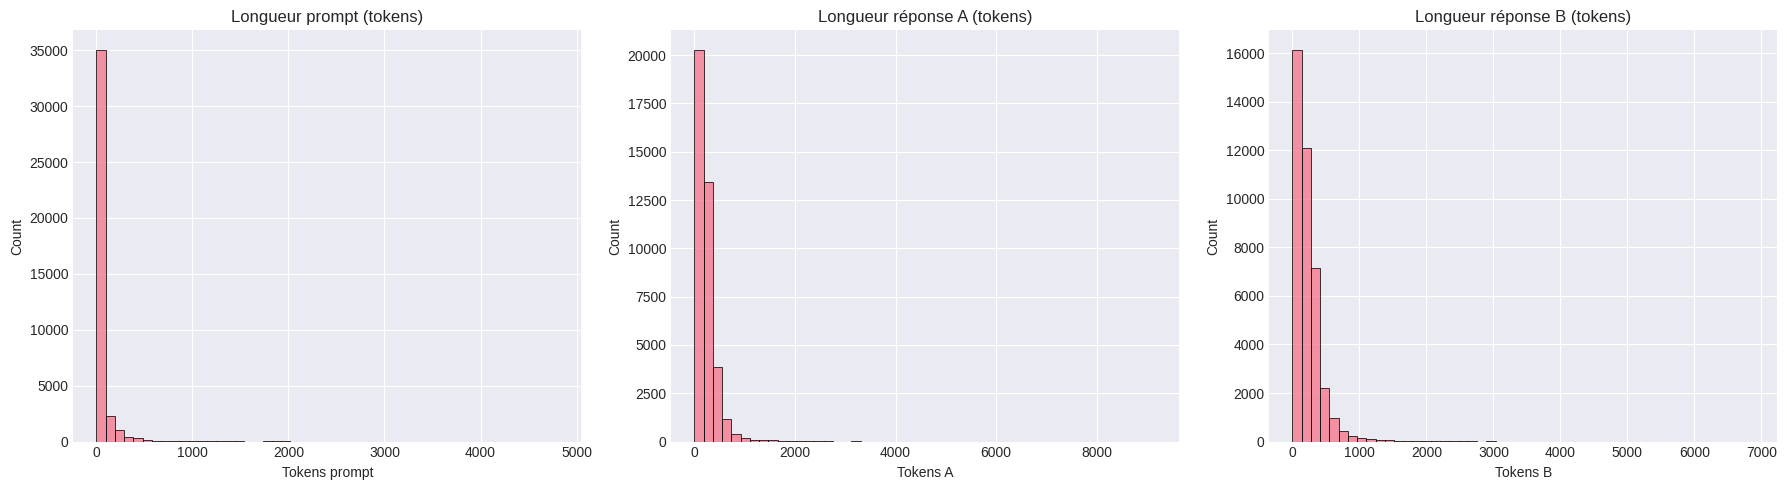

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df_binary["tokens_prompt"], bins=50, ax=axes[0])
axes[0].set_title("Longueur prompt (tokens)")
axes[0].set_xlabel("Tokens prompt")

sns.histplot(df_binary["tokens_a"], bins=50, ax=axes[1])
axes[1].set_title("Longueur réponse A (tokens)")
axes[1].set_xlabel("Tokens A")

sns.histplot(df_binary["tokens_b"], bins=50, ax=axes[2])
axes[2].set_title("Longueur réponse B (tokens)")
axes[2].set_xlabel("Tokens B")

plt.tight_layout()
plt.show()


# **CELL 12 — Visualisation des nouvelles features vs cible**

/tmp/ipython-input-1902312734.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["B wins (0)", "A wins (1)"])
/tmp/ipython-input-1902312734.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["B wins (0)", "A wins (1)"])
/tmp/ipython-input-1902312734.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(["B wins (0)", "A wins (1)"])


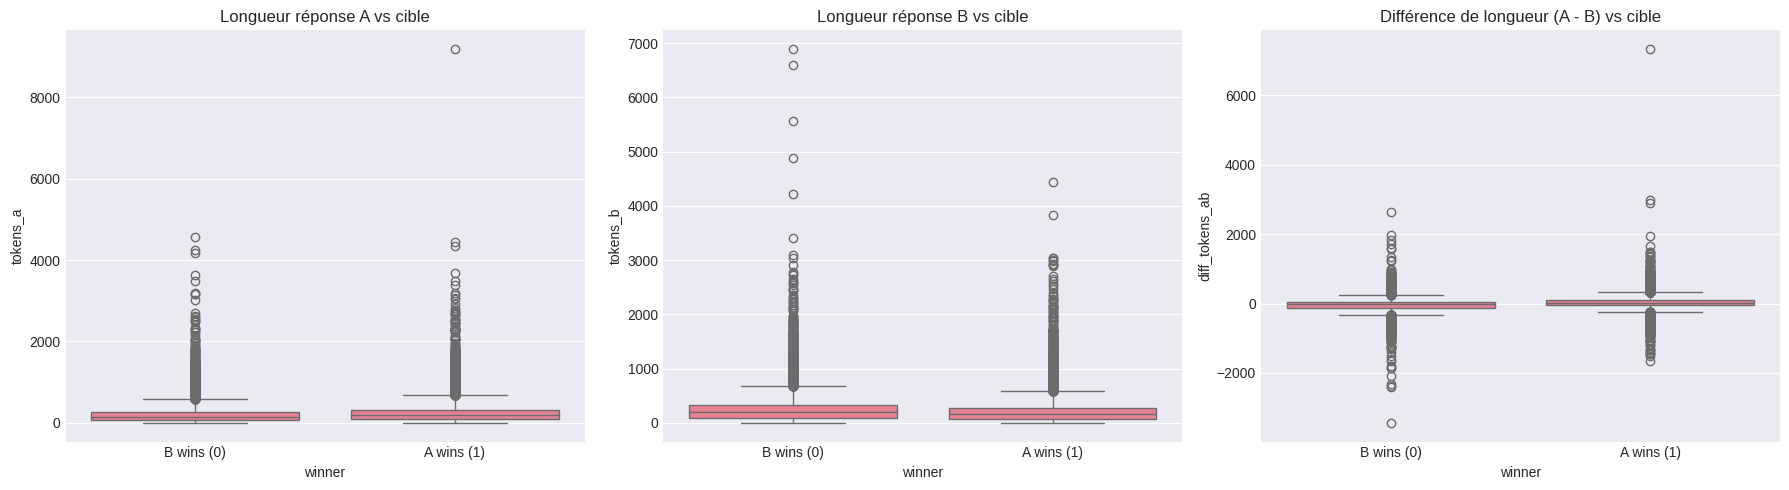

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x="winner", y="tokens_a", data=df_binary, ax=axes[0])
axes[0].set_xticklabels(["B wins (0)", "A wins (1)"])
axes[0].set_title("Longueur réponse A vs cible")

sns.boxplot(x="winner", y="tokens_b", data=df_binary, ax=axes[1])
axes[1].set_xticklabels(["B wins (0)", "A wins (1)"])
axes[1].set_title("Longueur réponse B vs cible")

sns.boxplot(x="winner", y="diff_tokens_ab", data=df_binary, ax=axes[2])
axes[2].set_xticklabels(["B wins (0)", "A wins (1)"])
axes[2].set_title("Différence de longueur (A - B) vs cible")

plt.tight_layout()
plt.show()


# **CELL 13 — Analyse des modèles (win rate par modèle)**

In [13]:
# Model A win rate
model_a_stats = (
    df_binary
    .groupby("model_a")["winner"]
    .agg(["count", "mean"])
    .rename(columns={"count": "nb_samples_as_A", "mean": "win_rate_as_A"})
    .sort_values("win_rate_as_A", ascending=False)
)

# Model B win rate (ici winner=0 signifie B gagne)
model_b_stats = (
    df_binary
    .assign(win_b=lambda d: 1 - d["winner"])  # 1 si B gagne
    .groupby("model_b")["win_b"]
    .agg(["count", "mean"])
    .rename(columns={"count": "nb_samples_as_B", "mean": "win_rate_as_B"})
    .sort_values("win_rate_as_B", ascending=False)
)

model_a_stats.head(10), model_b_stats.head(10)


(                    nb_samples_as_A  win_rate_as_A
 model_a                                           
 gpt-4-0125-preview              386       0.772021
 gpt-3.5-turbo-0314              484       0.758264
 gpt-4-1106-preview             2669       0.756463
 gpt-4-0314                     1478       0.698917
 claude-1                       1363       0.636097
 qwen1.5-72b-chat                190       0.615789
 gpt-4-0613                     2167       0.590678
 claude-instant-1               1455       0.569072
 claude-2.0                      908       0.559471
 mpt-30b-chat                    202       0.559406,
                     nb_samples_as_B  win_rate_as_B
 model_b                                           
 gpt-4-1106-preview             2691       0.763285
 gpt-4-0125-preview              412       0.723301
 gpt-3.5-turbo-0314              484       0.710744
 gpt-4-0314                     1445       0.664360
 claude-1                       1429       0.615815
 yi-34b-cha

# **CELL 14 — Fusion des stats A/B par modèle**

In [14]:
models_all = pd.merge(
    model_a_stats,
    model_b_stats,
    left_index=True,
    right_index=True,
    how="outer"
).fillna(0)

models_all["total_samples"] = models_all["nb_samples_as_A"] + models_all["nb_samples_as_B"]

# win_rate global approximatif (moyenne pondérée)
models_all["approx_global_win_rate"] = (
    (models_all["nb_samples_as_A"] * models_all["win_rate_as_A"] +
     models_all["nb_samples_as_B"] * models_all["win_rate_as_B"])
    / models_all["total_samples"].replace(0, np.nan)
)

models_all = models_all.sort_values("approx_global_win_rate", ascending=False)

models_all.head(15)


,nb_samples_as_A,win_rate_as_A,nb_samples_as_B,win_rate_as_B,total_samples,approx_global_win_rate
gpt-4-1106-preview,2669,0.756463,2691,0.763285,5360,0.759888
gpt-4-0125-preview,386,0.772021,412,0.723301,798,0.746867
gpt-3.5-turbo-0314,484,0.758264,484,0.710744,968,0.734504
gpt-4-0314,1478,0.698917,1445,0.664360,2923,0.681834
claude-1,1363,0.636097,1429,0.615815,2792,0.625716
qwen1.5-72b-chat,190,0.615789,180,0.544444,370,0.581081
gpt-4-0613,2167,0.590678,2139,0.546985,4306,0.568974
claude-instant-1,1455,0.569072,1467,0.554874,2922,0.561944
llama-2-70b-chat,1107,0.544715,1208,0.557947,2315,0.551620
claude-2.0,908,0.559471,833,0.537815,1741,0.549110


# **CELL 15 — Visualisation des modèles les plus fréquents**

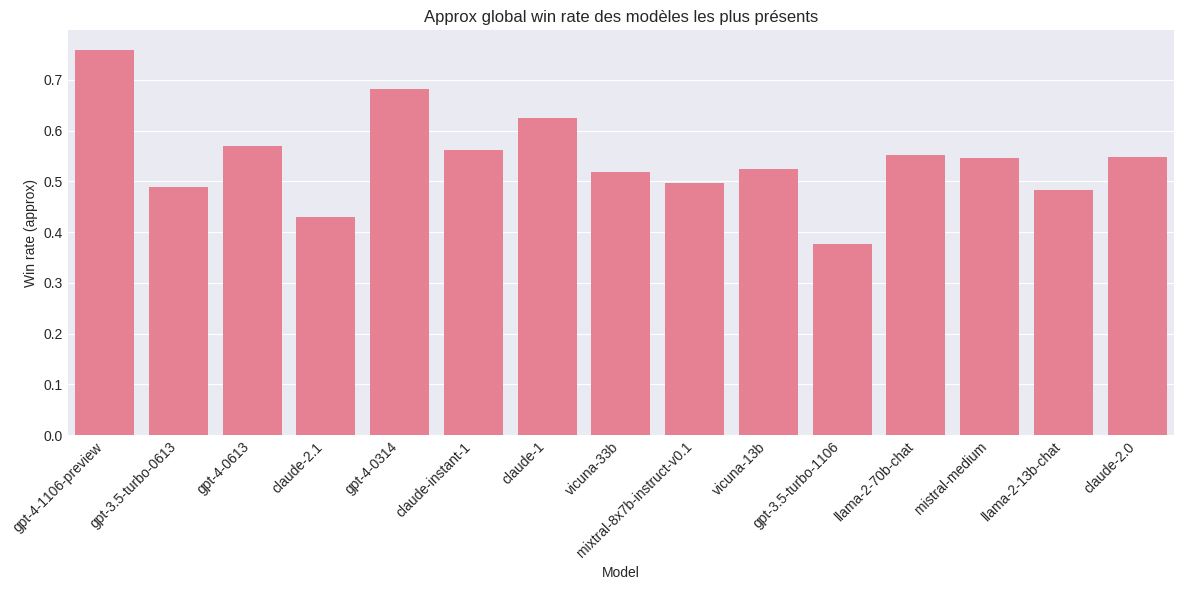

In [15]:
top_models = (
    models_all
    .sort_values("total_samples", ascending=False)
    .head(15)
    .reset_index()
    .rename(columns={"index": "model"})
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_models,
    x="model",
    y="approx_global_win_rate"
)
plt.xticks(rotation=45, ha="right")
plt.title("Approx global win rate des modèles les plus présents")
plt.ylabel("Win rate (approx)")
plt.xlabel("Model")
plt.tight_layout()
plt.show()


# **CELL 16 — (Optionnel) Sauvegarder un mini rapport EDA**

In [16]:
eda_summary = {
    "n_rows_total": int(df.shape[0]),
    "n_rows_binary": int(df_binary.shape[0]),
    "class_distribution": df_binary["winner"].value_counts(normalize=True).to_dict(),
    "mean_len_prompt": float(df_binary["len_prompt"].mean()),
    "mean_tokens_a": float(df_binary["tokens_a"].mean()),
    "mean_tokens_b": float(df_binary["tokens_b"].mean()),
}

eda_report_path = os.path.join(EDA_DIR, "eda_summary.json")
import json
with open(eda_report_path, "w") as f:
    json.dump(eda_summary, f, indent=2)

print("✅ EDA summary saved to:", eda_report_path)
eda_summary


✅ EDA summary saved to: /content/projet_llm/notebooks/eda/eda_summary.json


{'n_rows_total': 57477,
 'n_rows_binary': 39716,
 'class_distribution': {1: 0.5051868264679222, 0: 0.49481317353207777},
 'mean_len_prompt': 345.38334676201026,
 'mean_tokens_a': 220.08711854164568,
 'mean_tokens_b': 221.06390371638633}